In [1]:
import h5py
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"

cube = h5py.File(CUBE_PATH, "r")

spectra = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:]
metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]
sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")

In [3]:
sfrs_notna = sfrs[sfrs["FLAG"] == 0.0]

ind_metadata = metadata[:, 0]["ds_slice_idx"]
idx_annotation = np.isin(ind_metadata, sfrs_notna.index.values)

X_spectra = spectra[idx_annotation]
target_data = sfrs.loc[ind_metadata[idx_annotation], "TARGETTYPE"].values

In [4]:
def simplify_targettype(value):
    value = value.decode("utf-8").strip() 
    if "GALAXY" in value:
        return "GALAXY"
    elif "QSO" in value or "QA" in value:
        return "QUASAR"
    elif "STAR" in value:
        return "STAR"
    else:
        return "OTHER"

sfrs["Simplified_TARGETTYPE"] = sfrs["TARGETTYPE"].apply(simplify_targettype)
Y = sfrs.loc[ind_metadata[idx_annotation], "Simplified_TARGETTYPE"].values

In [5]:
nan_rows = np.isnan(X_spectra).any(axis=1)
X_spectra = X_spectra[~nan_rows]
Y = Y[~nan_rows]

label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

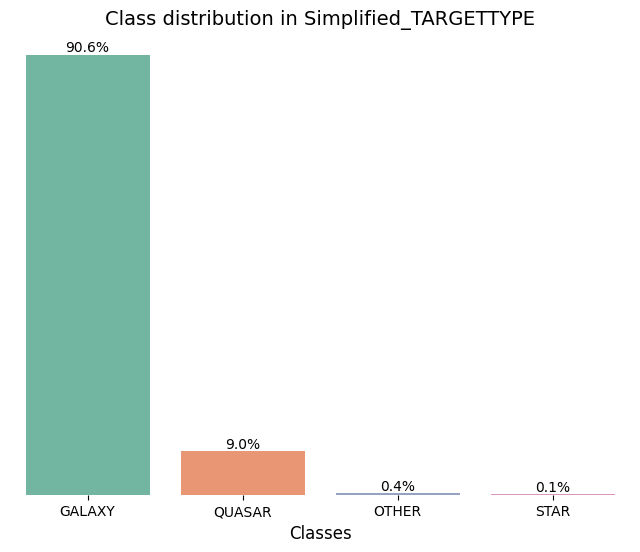

In [6]:
class_counts = pd.Series(Y).value_counts()
total_count = class_counts.sum()

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    x=class_counts.index,
    y=class_counts.values,
    hue=class_counts.index, 
    dodge=False,  
    palette=["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3"],
    legend=False
)

for i, count in enumerate(class_counts):
    percent = (count / total_count) * 100
    ax.text(i, count, f"{percent:.1f}%", ha='center', va='bottom', fontsize=10, color="black")

ax.yaxis.set_visible(False)

plt.title("Class distribution in Simplified_TARGETTYPE", fontsize=14)
plt.xlabel("Classes", fontsize=12)
plt.xticks(fontsize=10)
plt.box(False) 
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_spectra, Y_encoded, test_size=0.2, random_state=42)

dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.90      0.99      0.95      2016
       OTHER       0.00      0.00      0.00         6
      QUASAR       0.22      0.02      0.03       211
        STAR       0.00      0.00      0.00         3

    accuracy                           0.90      2236
   macro avg       0.28      0.25      0.25      2236
weighted avg       0.83      0.90      0.86      2236



/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

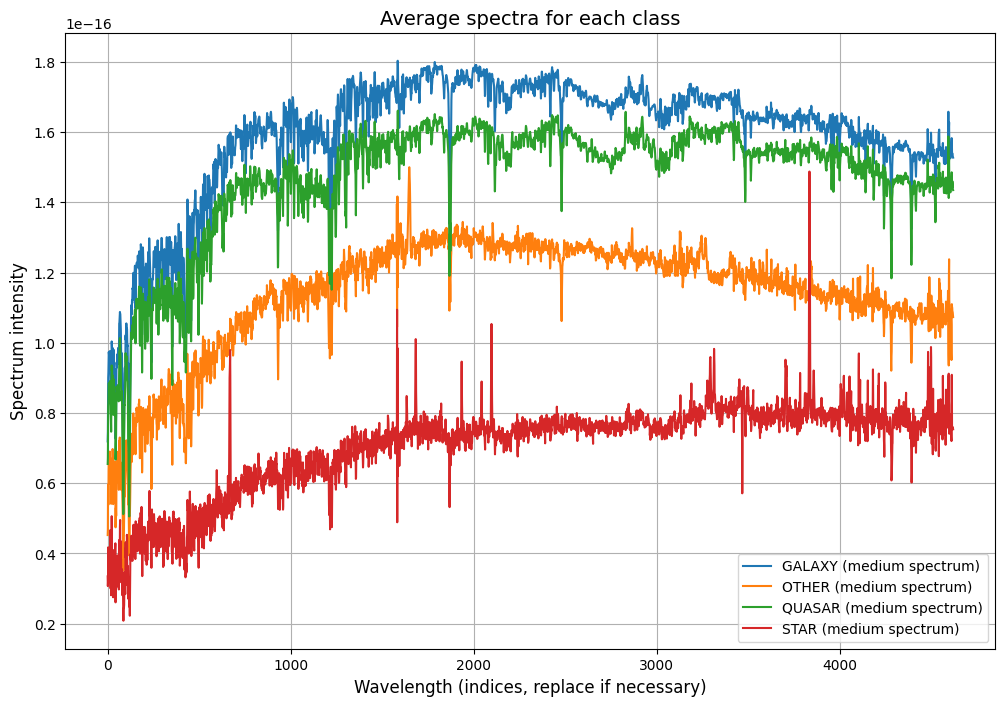

In [9]:
nan_rows = np.isnan(X_spectra).any(axis=1)

X_spectra_filtered = X_spectra[~nan_rows]
Y_encoded_filtered = Y_encoded[~nan_rows]

Y_decoded = label_encoder.inverse_transform(Y_encoded_filtered)

mean_spectra = {}

classes = np.unique(Y_decoded)
for cls in classes:
    mean_spectra[cls] = X_spectra_filtered[Y_decoded == cls].mean(axis=0)

plt.figure(figsize=(12, 8))

wavelengths = np.arange(X_spectra_filtered.shape[1]) 

for cls, spectrum in mean_spectra.items():
    plt.plot(wavelengths, spectrum, label=f"{cls} (medium spectrum)")

plt.title("Average spectra for each class", fontsize=14)
plt.xlabel("Wavelength (indices, replace if necessary)", fontsize=12)
plt.ylabel("Spectrum intensity", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()
